# Лабораторная работа 2

- ФТИИ
- ИИвП
- Гончаренко Данила
- J4250

In [23]:
!pip3 install -q -U langchain langchain_openai langgraph langchain_core langchain-community typing_extensions langchain_comu

ERROR: Could not find a version that satisfies the requirement langchain_comu (from versions: none)
ERROR: No matching distribution found for langchain_comu


In [24]:
from __future__ import annotations

import os, re, json, math, datetime
from typing import Any, Dict, List, Optional, Literal, TypedDict, Tuple

from pydantic import BaseModel, Field
from dotenv import load_dotenv

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, BaseMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.tools import tool
from langchain_core.output_parsers import PydanticOutputParser

from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import create_react_agent
import warnings
warnings.filterwarnings('ignore')

Подключаю свою модель

In [ ]:
import os
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_openai import ChatOpenAI



MODEL_NAME = os.getenv("OPENAI_MODEL_NAME", "qwen3-32b")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY", "sk-fhMGj3XMTsnLDUe__ClMLA")
OPENAI_API_BASE = os.getenv("OPENAI_API_BASE", "http://10.32.15.89:34000/v1")
NOTES_PATH = os.getenv("NOTES_PATH", "user_notes.json")


print("Model:", MODEL_NAME)
print("Base:", OPENAI_API_BASE)

Model: qwen3-32b
Base: http://10.32.15.89:34000/v1


In [48]:
def get_llm(temperature: float = 0.2) -> ChatOpenAI:
    return ChatOpenAI(model=MODEL_NAME, temperature=temperature, openai_api_key=OPENAI_API_KEY, openai_api_base = OPENAI_API_BASE)

In [28]:
"""
Блок со вспомогательными функциями 
Данные функции используются для единообразной трассировки и стабильной сериализации данных в узалах графа
"""

# Возвращаем текущую дату и время для логов
def now_iso() -> str:
    return datetime.datetime.now().isoformat(timespec="seconds")

# Приводит в единообразный ответ от модели и инструментов
def _coerce_text(x: Any) -> str:
    if x is None:   
        return ""
    if hasattr(x, "content"):
        return x.content
    return str(x)

# Подстраховка для PydanticOutputParser, чтоб точно получили ответ модели в необходимом формате
def _extract_json(text: str) -> Optional[Any]:
    if not text:
        return None
    text = text.strip()
    try:
        return json.loads(text)
    except Exception:
        pass
    m = re.search(r"(\{.*\}|\[.*\])", text, flags=re.DOTALL)
    if not m:
        return None
    try:
        return json.loads(m.group(1))
    except Exception:
        return None

# Уменьшаем размер строки для вывода ответов в логах
def _short(s: str, n: int = 240) -> str:
    s = (s or "").strip().replace("\n", " ")
    return s if len(s) <= n else s[:n] + "…"

# Храним историю вопросов и ответов (заданиче управления с памятью в лабораторной работе)
def add_history(state: "MASState", role: str, content: str):
    state["history"].append({"ts": now_iso(), "role": role, "content": content})

# Логируем факт вызова инструмента и его результат
def add_tool_log(state: "MASState", tool_name: str, payload: Any):
    state["tool_calls"].append({"ts": now_iso(), "tool": tool_name, "payload": payload})

# Логируем посещение узла графа LangGraph
def add_node_log(state: "MASState", node_name: str):
    state["activated_nodes"].append(node_name)

# Обрезаем историю диалога, оставляя только последние записи
def trim_history(state: "MASState", keep_last: int = 10):
    if len(state["history"]) > keep_last:
        state["history"] = state["history"][-keep_last:]

In [29]:
"""
Хранилище памяти
Сохраняем историю на диск в json-файл и извлекаем ответы по запросу
"""

# Загружаем историю из json-файла
def load_notes() -> List[Dict[str, Any]]:
    if not os.path.exists(NOTES_PATH):
        return []
    try:
        with open(NOTES_PATH, "r", encoding="utf-8") as f:
            data = json.load(f)
            return data if isinstance(data, list) else []
    except Exception:
        return []

# Сохраняем историю в json-файл
def save_notes(notes: List[Dict[str, Any]]) -> None:
    with open(NOTES_PATH, "w", encoding="utf-8") as f:
        json.dump(notes, f, ensure_ascii=False, indent=2)

# Добавляем в память ответ и сохраняем в файл
def append_note(notes: List[Dict[str, Any]], text: str, tags: Optional[List[str]] = None) -> Dict[str, Any]:
    note = {"ts": now_iso(), "text": (text or "").strip(), "tags": tags or []}
    notes.append(note)
    save_notes(notes)
    return note

# Работа с памятью
def simple_retrieve_notes(notes: List[Dict[str, Any]], query: str, k: int = 5) -> List[Dict[str, Any]]:
    """
    Алгоритм:
    1) Берем запрос и приводим к нижнему регистру, извлекаем токены длиной >= 3
    2) Для каждой заметки считаем "score" = сколько токенов запроса встречается в тексте ответа или в тегах
    3) Возвращаем топ ответов с максимальной оценкой

    Параметры:
    - notes: список заметок (list[dict])
    - query: запрос от пользователя или агента
    - k: сколько ответов нужно вернуть

    Возвращает:
    - список заметок (dict), наиболее релевантных запросу
    """
    q = (query or "").lower()
    tokens = set(re.findall(r"[a-zа-я0-9]{3,}", q))
    scored: List[Tuple[int, Dict[str, Any]]] = []
    for n in notes:
        text = (n.get("text", "") + " " + " ".join(n.get("tags", []))).lower()
        score = sum(1 for t in tokens if t in text)
        if score > 0:
            scored.append((score, n))
    scored.sort(key=lambda x: x[0], reverse=True)
    return [n for _, n in scored[:k]]

In [30]:
# PydanticOutputParser
def invoke_with_parser_retry(
        *,
        make_llm, 
        messages: List[BaseMessage],
        parser: PydanticOutputParser,
        max_retries: int = 3,
        temps: Tuple[float, ...] = (0.1, 0.2, 0.3),
) -> Any:
    """
    - make_llm: функция вида make_llm(temp) -> LLM. Нужна, чтобы удобно менять температуру на каждой попытке
    - messages: список сообщений (SystemMessage), которые передаются модели
    - parser: PydanticOutputParser, который знает целевую схему ответа
    - max_retries: максимальное число попыток (ограничиваем до 3х по заданию)
    - temps: набор температур по попыткам (увеличиваем на 0,1)
    """
    last_err: Optional[Exception] = None

    n = min(max_retries, len(temps))
    for i in range(n):
        llm = make_llm(temps[i])

        extra = ""
        if i > 0:
            extra = (
                "\nВАЖНО: верни ТОЛЬКО JSON без пояснений, без markdown, без лишнего текста.\n"
                "Даже если не уверен — верни валидный JSON по схеме.\n"
            )

        patched = list(messages)
        if patched and isinstance(patched[0], SystemMessage):
            patched[0] = SystemMessage(content=patched[0].content + extra)
        else:
            patched = [SystemMessage(content=extra)] + patched

        try:
            raw = llm.invoke(patched)
            text = _coerce_text(raw)
            return parser.parse(text)
        except Exception as e:
            last_err = e

    # Извлекаем jsonиз ответа
    raw = make_llm(temps[-1]).invoke(messages)
    text = _coerce_text(raw)
    data = _extract_json(text)
    if data is not None:
        return parser.pydantic_object.model_validate(data)

    raise last_err or ValueError("Не удалось проанализировать ответ модели")

In [54]:
# Инструменты для агентов
@tool("calc")
def calc(expression: str) -> str:
    """
    Для вычисления простых математических формул 
    """""
    if not re.fullmatch(r"[0-9\.\+\-\*\/\(\)\s]+", expression or ""):
        return "Ошибка: недопустимые символы в выражении"
    try:
        val = eval(expression, {"__builtins__": {}}, {"math": math})
        return str(val)
    except Exception as e:
        return f"Ошибка вычисления: {e}"

@tool("days_until")
def days_until(date_iso: str) -> str:
    """
    Считаем количество дней до заданной даты для планирования бытовых задач
    """""
    try:
        target = datetime.date.fromisoformat((date_iso or "").strip())
        today = datetime.date.today()
        return str((target - today).days)
    except Exception:
        return "Ошибка: ожидаю дату в формате YYYY-MM-DD"

@tool("save_user_note")
def save_user_note(text: str, tags_json: str = "[]") -> str:
    """
    Сохраняем пользовательский вопрос в файл
    """
    try:
        tags = json.loads(tags_json) if tags_json else []
        if not isinstance(tags, list):
            tags = []
    except Exception:
        tags = []
        
    # Загружаем текущие ответы, добавляем новую и сохраняем
    notes = load_notes()
    note = append_note(notes, text=text, tags=tags)
    return json.dumps(note, ensure_ascii=False)

@tool("search_user_notes")
def search_user_notes(query: str, k: int = 5) -> str:
    """
    Ищем релевантные ответы в файле с историей 
    """
    notes = load_notes()
    hits = simple_retrieve_notes(notes, query=query, k=k)
    return json.dumps(hits, ensure_ascii=False)

@tool("create_table")
def create_table(data_json: str) -> str:
    """
    Создает таблицу в формате Markdown из структурированных данных.
    
    Параметры:
    - data_json: строка в формате JSON с ключами:
        * headers: список названий столбцов (обязательно)
        * rows: список строк, каждая строка - список значений (обязательно)
        * caption: заголовок таблицы (опционально)
        * alignment: выравнивание столбцов (опционально, по умолчанию "left")
          Формат: список значений ["left", "center", "right"] по количеству столбцов
    
   
    
    Особенности:
    - Автоматическое форматирование чисел и дат
    - Поддержка многострочных ячеек
    - Валидация структуры данных
    - Экранирование специальных символов Markdown
    """
    try:
        # Парсинг JSON
        data = json.loads(data_json)
        
        # Валидация обязательных полей
        if "headers" not in data or "rows" not in data:
            return "Ошибка: отсутствуют обязательные поля 'headers' или 'rows' в JSON"
        
        headers = data["headers"]
        rows = data["rows"]
        caption = data.get("caption", "")
        alignment = data.get("alignment", ["left"] * len(headers))
        
        # Проверка соответствия количества столбцов
        num_cols = len(headers)
        if len(alignment) != num_cols:
            alignment = ["left"] * num_cols
        
        # Валидация строк
        for i, row in enumerate(rows):
            if len(row) != num_cols:
                return f"Ошибка: строка {i+1} содержит {len(row)} элементов, ожидается {num_cols}"
        
        # Функция для экранирования Markdown-спецсимволов
        def escape_markdown(text):
            if not isinstance(text, str):
                return str(text)
            # Экранируем только символы, которые могут нарушить форматирование таблицы
            return text.replace("|", "\\|").replace("\n", "<br>")
        
        # Формирование разделителя с учетом выравнивания
        def get_alignment_marker(align):
            if align == "center":
                return ":---:"
            elif align == "right":
                return "---:"
            else:
                return ":---"
        
        # Форматирование таблицы
        table_lines = []
        
        # Добавление заголовка, если есть
        if caption:
            table_lines.append(f"**{escape_markdown(caption)}**\n")
        
        # Заголовки
        header_row = "| " + " | ".join(escape_markdown(h) for h in headers) + " |"
        table_lines.append(header_row)
        
        # Разделитель с выравниванием
        separator = "| " + " | ".join(get_alignment_marker(align) for align in alignment) + " |"
        table_lines.append(separator)
        
        # Строки данных
        for row in rows:
            formatted_row = "| " + " | ".join(escape_markdown(cell) for cell in row) + " |"
            table_lines.append(formatted_row)
        
        # Добавление подписи к таблице (опционально)
        if caption:
            table_lines.append(f"\n_Таблица 1: {escape_markdown(caption)}_")
        
        return "\n".join(table_lines)
    
    except json.JSONDecodeError as e:
        return f"Ошибка парсинга JSON: {str(e)}"
    except TypeError as e:
        return f"Ошибка типа данных: {str(e)}"
    except Exception as e:
        return f"Ошибка создания таблицы: {str(e)}"

# Для бытовых задач
TOOLS_DAILY = [calc, days_until, save_user_note, search_user_notes]

# Для задач программирования
TOOLS_CODING = [calc, save_user_note, search_user_notes]

# Для задач литературных 
TOOLS_LITERATURE = [save_user_note, search_user_notes, create_table]

# Для задач с составлением таблиц
TOOLS_DATABASE = [calc, save_user_note, search_user_notes, create_table]

In [55]:
def gather_tools_node(state: MASState) -> MASState:
    """
    gather_tools – агент добора информации через инструменты
    
    Роль в системе:
    - Это узел, который через ReAct tool calling добирает недостающую информацию перед основным ответом
    - Узел используется также как часть цикла улучшения: reviewer может вернуть approved=False + focus, после чего мы снова заходим в gather_tools_node, чтобы добрать контекст
    """
    add_node_log(state, "gather_tools")

    if state["intent"] == "coding":
        tools = TOOLS_CODING
    elif state["intent"] == "daily":
        tools = TOOLS_DAILY
    elif state["intent"] == "literature":
        tools = TOOLS_LITERATURE
    elif state["intent"] == "table":
        tools = TOOLS_DATABASE
    else:
        tools = [search_user_notes, save_user_note]

    llm = get_llm(temperature=0.1)
    prompt = ChatPromptTemplate.from_messages([
        ("system",
         "Ты — агент добора информации через инструменты.\n"
         "Твоя задача — добрать недостающие данные, следуя focus.\n"
         "Всегда начинай с поиска в заметках (search_user_notes), если это уместно.\n"
         "Используй инструменты строго по необходимости.\n"
         "После добора кратко резюмируй, что нашёл.\n"),
        ("placeholder", "{messages}")
    ])
    
    # Испольщуем create_react_agent из примера мультиагентной системы
    agent = create_react_agent(model=llm, tools=tools, prompt=prompt)

    user_msg = (
        # Запрос
        f"QUERY: {state['query']}\n"
        
        # Тип вопроса от пользователя
        f"INTENT: {state['intent']}\n"
        
        # План
        f"PLAN: {state['plan']}\n"
        
        # Какую информацию нужно дособрать 
        f"FOCUS: {state.get('focus','')}\n"
        
        # Информация, которая есть в памяти
        f"MEMORY_HITS: {state.get('memory_hits', [])}\n"
        
        # Какие результаты у интрументов уже были
        f"TOOL_CONTEXT_TAIL: {state.get('tool_context', [])[-5:]}\n"
        
        # Итеративный процесс
        f"ROUND: {state.get('round', 0)} / {state.get('max_rounds', 3)}\n"
    )

    res = agent.invoke(
        {"messages": [HumanMessage(content=user_msg)]},
        config={"recursion_limit": 30, "configurable": {"thread_id": state["thread_id"]}}
    )

    state.setdefault("tool_calls", [])
    state.setdefault("tool_context", [])
    
    # Сохраняем результаты инструментов
    for m in res["messages"]:
        if m.__class__.__name__.startswith("ToolMessage"):
            content = getattr(m, "content", "")
            add_tool_log(state, "tool_message", {"content": content})

            state["tool_context"].append({"ts": now_iso(), "tool_message": content})
            state["tool_calls"].append({
                "ts": now_iso(),
                "node": "gather_tools",
                "type": "ToolMessage",
                "payload": {"content": content},
            })
    
    # Сообщение агента 
    summary = _coerce_text(res["messages"][-1])
    state["tool_context"].append({"ts": now_iso(), "gather_summary": summary})

    # Счетчик итераций
    """
    Нужно для остановки цикла
    Была ошибка, что модель зацикливалась, поэтому добавила
    """
    state["round"] = int(state.get("round", 0)) + 1

    return state


In [ ]:
"""
Передача состояний между узлами графа
Типы запросов пользовтеля: 
- conceptual – 
- architecture – вопрос архитектуры
- coding – вопрос программирования
- daily – повседеневный вопрос
- literature – обзор литературы 
- table - создание таблиц со ссылками
"""

Intent = Literal["conceptual", "architecture", "coding", "daily", "literature", "table"]

class MASState(TypedDict):
    query: str                           # Запрос пользователя
    intent: Optional[Intent]             # Тип запроса пользователя
    plan: List[str]                      # План решение от планировщика
    tool_context: List[Dict[str, Any]]   # Накопленная информация от интрументов
    focus: str                           # Какую информацию еще необходимо собрать
    need_more: bool                      # Флаг для понимания нужно ли делать новый запрос интрументу
    round: int                           # Итерация цикла
    max_rounds: int                      # Максимальное количество итераций цикла
    partial: str                         # Промежуточный ответ агента
    final_answer: str                    # Финальный ответ агента
    history: List[Dict[str, Any]]        # История диалога
    memory_notes: List[Dict[str, Any]]   # История пользователя из файла
    memory_hits: List[Dict[str, Any]]    # Результаты поиска по истории из файла
    memory_summary: str                  # Резюме об использовании памяти
    activated_nodes: List[str]           # Список узлов
    tool_calls: List[Dict[str, Any]]     # Лог вызова инструментов
    handoff_log: List[str]               # Передача информации между агентами
    thread_id: str                       # id сессии
    verbose: bool


In [56]:
# Planner схема
class RouteDecision(BaseModel):
    intent: Intent = Field(..., description="Маршрут: conceptual|architecture|coding|daily|literature|table")
    reasoning: str = Field("", description="Коротко почему так")

class PlanOut(BaseModel):
    plan: List[str] = Field(..., description="5–10 шагов плана")

class ReviewDecision(BaseModel):
    need_more: bool = Field(..., description="Нужно ли добирать информацию через инструменты")
    focus: str = Field("", description="Что конкретно добрать/уточнить (коротко)")
    improved_answer: str = Field("", description="Улучшенная версия текста, если уже можно улучшить без добора")

class ExperimentComment(BaseModel):
    helpful: bool = Field(..., description="Был ли ответ полезен пользователю")
    issues: List[str] = Field(default_factory=list, description="Что было не так (коротко)")
    improvements: List[str] = Field(default_factory=list, description="Что улучшить (коротко и конкретно)")


In [59]:
# Агенты (ноды)
def router_node(state: MASState) -> MASState:
    """
    Определяет тип запроса пользователя и фиксирует handoff
    """
    add_node_log(state, "router")

    # Долговременная память
    notes = load_notes()
    hits = simple_retrieve_notes(notes, state["query"], k=4)
    state["memory_notes"] = notes
    state["memory_hits"] = hits
    
    # Отчет роутера парсим с помощью PydanticOutputParser
    parser = PydanticOutputParser(pydantic_object=RouteDecision)

    system = (
        "Ты — Router мультиагентной системы.\n"
        "Определи intent запроса одним из:\n"
        "- conceptual: теоретика Computer Vision\n"
        "- architecture: проектирование/архитектура\n"
        "- coding: реализация/код\n"
        "- daily: повседневные задачи\n"
        "- literature: поиск/обзор литературы\n"
        "- table: структурирование/таблицы\n"
        "Ответ строго JSON по схеме.\n"
        f"{parser.get_format_instructions()}"
    )

    ctx = {"query": state["query"], "memory_hits": hits, "history_tail": state["history"][-4:]}

    def make_llm(temp: float):
        return get_llm(temperature=temp)

    decision: RouteDecision = invoke_with_parser_retry(
        make_llm=make_llm,
        messages=[
            SystemMessage(content=system),
            HumanMessage(content=json.dumps(ctx, ensure_ascii=False)),
        ],
        parser=parser,
        max_retries=3,
        temps=(0.1, 0.2, 0.3),
    )

    state["intent"] = decision.intent
    # Фиксируем handoff router передал управление нужному агенту
    state["handoff_log"].append(f"[handoff] router -> {decision.intent} | {decision.reasoning}")

    # Обновляем историю диалога в оперативной памяти сессии
    add_history(state, "user", state["query"])
    trim_history(state)
    return state

# Узел Planner: строит план ответа из 5–10 шагов под запрос пользователя
def planner_node(state: MASState) -> MASState:
    add_node_log(state, "planner")

    parser = PydanticOutputParser(pydantic_object=PlanOut)
    system = (
        "Ты — Planner.\n"
        "Составь короткий план решения из 5–10 шагов по запросу пользователя.\n"
        "Учитывай intent, memory_hits и историю.\n"
        "Ответ строго JSON по схеме.\n"
        f"{parser.get_format_instructions()}"
    )

    ctx = {
        "query": state["query"],
        "intent": state["intent"],
        "memory_hits": state["memory_hits"],
        "history_tail": state["history"][-4:],
    }

    def make_llm(temp: float):
        return get_llm(temperature=temp)

    out: PlanOut = invoke_with_parser_retry(
        make_llm=make_llm,
        messages=[
            SystemMessage(content=system),
            HumanMessage(content=json.dumps(ctx, ensure_ascii=False)),
        ],
        parser=parser,
        max_retries=3,
        temps=(0.2, 0.5, 0.8),
    )

    plan = out.plan if isinstance(out.plan, list) and out.plan else []
    if not plan:
        plan = ["Уточнить цель", "Собрать контекст", "Сформировать ответ", "Проверить результат"]

    state["plan"] = [str(x) for x in plan][:12]
    return state

# Вызывает LLM и формирует теоретический структурированный ответ: определения, ключевые идеи
def conceptual_agent_node(state: MASState) -> MASState:
    add_node_log(state, "conceptual_agent")

    llm = get_llm(temperature=0.2)
    system = (
        "Ты — conceptual-агент (теория Computer Vision системы).\n"
        "Дай структурированный ответ: определения, ключевые идеи, 1–2 примера.\n"
        "Опирайся на plan + memory_hits + tool_context.\n"
        "Если чего-то не хватает — явно укажи, что именно.\n"
    )

    ctx = {
        "query": state["query"],
        "plan": state.get("plan", []),
        "memory_hits": state.get("memory_hits", []),
        "tool_context_tail": state.get("tool_context", [])[-8:],
        "history_tail": state.get("history", [])[-4:],
    }

    raw = llm.invoke([
        SystemMessage(content=system),
        HumanMessage(content=json.dumps(ctx, ensure_ascii=False))
    ])
    state["partial"] = _coerce_text(raw)
    return state

# Агент, который генерирует ответ по структуре (компоненты, state, handoff, tools, memory)
def architecture_agent_node(state: MASState) -> MASState:
    add_node_log(state, "architecture_agent")

    llm = get_llm(temperature=0.2)
    system = (
        "Ты — architecture-агент (архитектура/дизайн).\n"
        "Сформируй ответ с блоками:\n"
        "1) компоненты и роли агентов,\n"
        "2) state поля,\n"
        "3) handoff/маршрутизация,\n"
        "4) tool calling,\n"
        "5) memory management,\n"
        "6) риски и улучшения.\n"
        "Опирайся на plan + memory_hits + tool_context.\n"
    )

    ctx = {
        "query": state["query"],
        "plan": state.get("plan", []),
        "memory_hits": state.get("memory_hits", []),
        "tool_context_tail": state.get("tool_context", [])[-8:],
        "history_tail": state.get("history", [])[-4:],
    }

    raw = llm.invoke([
        SystemMessage(content=system),
        HumanMessage(content=json.dumps(ctx, ensure_ascii=False))
    ])
    state["partial"] = _coerce_text(raw)
    return state

# Проверка похожести ответа от модели на код (нужно для кодингового агента)
def _looks_like_code(text: str) -> bool:
    t = (text or "")
    if "```" in t:
        return True
    # Эвристики
    return any(x in t for x in ["def ", "class ", "import ", "from ", "pip install", "```python"])

# Кодинговый ответ
def coding_agent_node(state: MASState) -> MASState:
    add_node_log(state, "coding_agent")

    tools = TOOLS_CODING
    prompt = ChatPromptTemplate.from_messages([
        ("system",
         "Ты — coding-агент.\n"
         "Твоя задача: выдать ИСПОЛНИМЫЙ код.\n"
         "Формат ответа ОБЯЗАТЕЛЕН:\n"
         "1) Один кодовый блок ```python ... ``` (или ```bash``` если нужно)\n"
         "2) Ниже 2–5 строк инструкции как запустить.\n"
         "3) Обязательно напиши код по синтаксическим правилам написания кода. \n"
         "Если не хватает данных — предположи разумные значения и отметь TODO в коде.\n"
         "Инструменты: calc, search_user_notes, save_user_note.\n"
         "Если полезно — сначала search_user_notes.\n"),
        ("placeholder", "{messages}")
    ])

    user_msg = (
        f"QUERY: {state['query']}\n"
        f"PLAN: {state.get('plan', [])}\n"
        f"MEMORY_HITS: {state.get('memory_hits', [])}\n"
        f"TOOL_CONTEXT_TAIL: {state.get('tool_context', [])[-8:]}\n"
        f"HISTORY_TAIL: {state.get('history', [])[-4:]}\n"
    )

    # 1-я попытка
    llm = get_llm(temperature=0.0)
    agent = create_react_agent(model=llm, tools=tools, prompt=prompt)
    res = agent.invoke(
        {"messages": [HumanMessage(content=user_msg)]},
        config={"recursion_limit": 40, "configurable": {"thread_id": state["thread_id"]}}
    )

    # Логируем ответы интрументов
    for m in res["messages"]:
        if m.__class__.__name__.startswith("ToolMessage"):
            content = getattr(m, "content", "")
            add_tool_log(state, "tool_message", {"content": content})
            state["tool_context"].append({"ts": now_iso(), "tool_message": content})

    text = _coerce_text(res["messages"][-1])

    # 2-я попытка, если кода нет
    if not _looks_like_code(text):
        llm2 = get_llm(temperature=0.4)
        agent2 = create_react_agent(model=llm2, tools=tools, prompt=prompt)
        res2 = agent2.invoke(
            {"messages": [HumanMessage(content=user_msg + "\n\nВАЖНО: верни ответ строго в формате: ```python``` + инструкции.")]},
            config={"recursion_limit": 40, "configurable": {"thread_id": state["thread_id"]}}
        )
        for m in res2["messages"]:
            if m.__class__.__name__.startswith("ToolMessage"):
                content = getattr(m, "content", "")
                add_tool_log(state, "tool_message", {"content": content})
                state["tool_context"].append({"ts": now_iso(), "tool_message": content})
        text = _coerce_text(res2["messages"][-1])

    state["partial"] = text
    return state

# Агент повседневного типа ответов
def daily_agent_node(state: MASState) -> MASState:
    add_node_log(state, "daily_agent")

    tools = TOOLS_DAILY
    llm = get_llm(temperature=0.0)

    prompt = ChatPromptTemplate.from_messages([
        ("system",
         "Ты — daily-агент (повседневные задачи).\n"
         "Инструменты: days_until, calc, search_user_notes, save_user_note.\n"
         "Если есть дата/дедлайн — days_until.\n"
         "Если есть расчёты — calc.\n"
         "Если выдаёшь полезный план/чеклист — сохрани save_user_note.\n"),
        ("placeholder", "{messages}")
    ])

    agent = create_react_agent(model=llm, tools=tools, prompt=prompt)

    user_msg = (
        f"QUERY: {state['query']}\n"
        f"PLAN: {state.get('plan', [])}\n"
        f"MEMORY_HITS: {state.get('memory_hits', [])}\n"
        f"TOOL_CONTEXT_TAIL: {state.get('tool_context', [])[-8:]}\n"
        f"HISTORY_TAIL: {state.get('history', [])[-4:]}\n"
    )

    res = agent.invoke(
        {"messages": [HumanMessage(content=user_msg)]},
        config={"recursion_limit": 40, "configurable": {"thread_id": state["thread_id"]}}
    )

    for m in res["messages"]:
        if m.__class__.__name__.startswith("ToolMessage"):
            content = getattr(m, "content", "")
            add_tool_log(state, "tool_message", {"content": content})
            state["tool_context"].append({"ts": now_iso(), "tool_message": content})

    state["partial"] = _coerce_text(res["messages"][-1])
    return state

# Агент обзора литературы
def literature_agent_node(state: MASState) -> MASState:
    add_node_log(state, "literature_agent")

    tools = TOOLS_LITERATURE
    llm = get_llm(temperature=0.0)

    prompt = ChatPromptTemplate.from_messages([
        ("system",
         "Ты — literature-агент.\n"
         "Сформируй:\n"
         "1) 5–10 поисковых запросов (лучше на английском)\n"
         "2) критерии отбора статей\n"
         "3) структуру обзора\n"
         "Инструменты: search_user_notes, save_user_note.\n"
         "Если есть полезные выводы — сохрани заметку.\n"),
        ("placeholder", "{messages}")
    ])

    agent = create_react_agent(model=llm, tools=tools, prompt=prompt)

    user_msg = (
        f"QUERY: {state['query']}\n"
        f"PLAN: {state.get('plan', [])}\n"
        f"MEMORY_HITS: {state.get('memory_hits', [])}\n"
        f"TOOL_CONTEXT_TAIL: {state.get('tool_context', [])[-8:]}\n"
        f"HISTORY_TAIL: {state.get('history', [])[-4:]}\n"
    )

    res = agent.invoke(
        {"messages": [HumanMessage(content=user_msg)]},
        config={"recursion_limit": 40, "configurable": {"thread_id": state["thread_id"]}}
    )

    for m in res["messages"]:
        if m.__class__.__name__.startswith("ToolMessage"):
            content = getattr(m, "content", "")
            add_tool_log(state, "tool_message", {"content": content})
            state["tool_context"].append({"ts": now_iso(), "tool_message": content})

    state["partial"] = _coerce_text(res["messages"][-1])
    return state

# Агент по созданию таблиц
def table_agent_node(state: MASState) -> MASState:
    add_node_log(state, "table_agent")

    tools = TOOLS_DATABASE
    llm = get_llm(temperature= 0.0)

    prompt = ChatPromptTemplate.from_messages([
        (
            "system",
            "Ты - агент по созданию таблиц\n",
            "Сформируй таблицу с найденными источниками. Она должна влючать в себя:\n",
            "1) Номер\n",
            "2) Название статьи\n",
            "3) Имя автора\n",
            "4) Ссылку на источник\n"
            "Инструменты: search_user_notes, table, save_user_notes\n"
        ),
        ("placeholder", "{messages}")

    ])
    agent = create_react_agent(model=llm, tools=tools, prompt=prompt)

    user_msg = (
        f"QUERY: {state['query']}\n"
        f"PLAN: {state.get('plan', [])}\n"
        f"MEMORY_HITS: {state.get('memory_hits', [])}\n"
        f"TOOL_CONTEXT_TAIL: {state.get('tool_context', [])[-8:]}\n"
        f"HISTORY_TAIL: {state.get('history', [])[-4:]}\n"
    )

    res = agent.invoke(
        {"messages": [HumanMessage(content=user_msg)]},
        config={"recursion_limit": 40, "configurable": {"thread_id": state["thread_id"]}}
    )

    for m in res["messages"]:
        if m.__class__.__name__.startswith("ToolMessage"):
            content = getattr(m, "content", "")
            add_tool_log(state, "tool_message", {"content": content})
            state["tool_context"].append({"ts": now_iso(), "tool_message": content})

    state["partial"] = _coerce_text(res["messages"][-1])
    return state

# Ревьюер
def reviewer_node(state: MASState) -> MASState:
    add_node_log(state, "reviewer")

    parser = PydanticOutputParser(pydantic_object=ReviewDecision)

    system = (
        "Ты — reviewer.\n"
        "Проверь: хватает ли информации для хорошего ответа.\n"
        "Если НЕ хватает: need_more=true и в focus напиши ЧТО добрать через инструменты.\n"
        "Если хватает: need_more=false и improved_answer содержит улучшенную версию (или пусто).\n"
        "Ответ строго JSON.\n"
        f"{parser.get_format_instructions()}"
    )

    ctx = {
        "query": state["query"],
        "intent": state["intent"],
        "plan": state["plan"],
        "draft": state["partial"],
        "tool_context_tail": state["tool_context"][-8:],
        "memory_hits": state["memory_hits"],
        "round": state["round"],
        "max_rounds": state["max_rounds"],
    }

    def make_llm(temp: float):
        return get_llm(temperature=temp)

    decision: ReviewDecision = invoke_with_parser_retry(
        make_llm=make_llm,
        messages=[
            SystemMessage(content=system),
            HumanMessage(content=json.dumps(ctx, ensure_ascii=False)),
        ],
        parser=parser,
        max_retries=3,
        temps=(0.0, 0.4, 0.8),
    )

    # Ограничение по числу циклов
    if state["round"] >= state["max_rounds"]:
        decision.need_more = False

    state["need_more"] = decision.need_more
    state["focus"] = (decision.focus or "").strip()

    if (not decision.need_more) and decision.improved_answer.strip():
        state["partial"] = decision.improved_answer.strip()

    return state

def route_after_reviewer(state: MASState) -> str:
    return "gather_tools" if state.get("need_more") else "finalize"

def finalize_node(state: MASState) -> MASState:
    add_node_log(state, "finalize")

    state["final_answer"] = (state["partial"] or "").strip()
    add_history(state, "assistant", state["final_answer"])
    trim_history(state)

    if state["memory_hits"]:
        state["memory_summary"] = "Использованы заметки: " + "; ".join(_short(h.get("text",""), 60) for h in state["memory_hits"][:3])
    else:
        state["memory_summary"] = "Заметки по теме не найдены."

    return state

def route_after_planner(state: MASState) -> str:
    return state.get("intent") or "daily"

In [ ]:
# Модель говорит что можно было бы улучшить
def make_experiment_comment(llm_factory, out: dict) -> ExperimentComment:
    parser = PydanticOutputParser(pydantic_object=ExperimentComment)

    system = (
        "Ты — строгий оценщик качества ответа мультиагентной системы.\n"
        "Оцени полезность результата и укажи, что улучшить.\n"
        "Ориентируйся на:\n"
        "- корректность intent/маршрутизации,\n"
        "- осмысленность tool calls,\n"
        "- использовалась ли память по делу,\n"
        "- полноту и конкретику ответа.\n"
        "Ответ строго JSON по схеме.\n"
        f"{parser.get_format_instructions()}"
    )

    ctx = {
        "query": out.get("query"),
        "intent": out.get("intent"),
        "activated_nodes": out.get("activated_nodes", []),
        "handoff_log": out.get("handoff_log", []),
        "tools_used_count": len(out.get("tool_calls", [])),
        "tool_calls_tail": out.get("tool_calls", [])[-8:],
        "memory_summary": out.get("memory_summary", ""),
        "memory_hits": out.get("memory_hits", []),
        "final_answer": out.get("final_answer", ""),
    }

    def make_llm(temp: float):
        return llm_factory(temp)

    comment: ExperimentComment = invoke_with_parser_retry(
        make_llm=make_llm,
        messages=[
            SystemMessage(content=system),
            HumanMessage(content=json.dumps(ctx, ensure_ascii=False))
        ],
        parser=parser,
        max_retries=3,
        temps=(0.0, 0.3, 0.7),
    )
    return comment

In [63]:
# Визуализация графа
def build_graph_with_retry_loop():
    g = StateGraph(MASState)

    g.add_node("router", router_node)
    g.add_node("planner", planner_node)

    g.add_node("gather_tools", gather_tools_node)

    g.add_node("conceptual_agent", conceptual_agent_node)
    g.add_node("architecture_agent", architecture_agent_node)
    g.add_node("coding_agent", coding_agent_node)
    g.add_node("daily_agent", daily_agent_node)
    g.add_node("literature_agent", literature_agent_node)
    g.add_node("table_agent", table_agent_node)

    g.add_node("reviewer", reviewer_node)
    g.add_node("finalize", finalize_node)

    g.set_entry_point("router")
    g.add_edge("router", "planner")

    # planner -> gather_tools (первичный добор)
    g.add_edge("planner", "gather_tools")

    # gather_tools -> chosen agent (handoff по intent)
    g.add_conditional_edges(
        "gather_tools",
        lambda s: s.get("intent") or "daily",
        {
            "conceptual": "conceptual_agent",
            "architecture": "architecture_agent",
            "coding": "coding_agent",
            "daily": "daily_agent",
            "literature": "literature_agent",
            "table": "table_agent"
        }
    )

    # Агент -> ревьюер
    for node in ["conceptual_agent","architecture_agent","coding_agent","daily_agent","literature_agent", "table_agent"]:
        g.add_edge(node, "reviewer")

    # Ревьюер -> интрумент
    g.add_conditional_edges(
        "reviewer",
        route_after_reviewer,
        {"gather_tools": "gather_tools", "finalize": "finalize"}
    )

    g.add_edge("finalize", END)

    return g.compile(checkpointer=MemorySaver())


In [64]:
# Запускаем пайплайн мультиагентоной системы
def run_system(query: str, thread_id: str = "u1", max_rounds: int = 3):
    app = build_graph_with_retry_loop()

    init = {
        "query": query,
        "intent": None,
        "plan": [],
        "tool_context": [],
        "focus": "",
        "need_more": False,
        "round": 0,
        "max_rounds": max_rounds,
        "partial": "",
        "final_answer": "",
        "history": [],
        "memory_notes": [],
        "memory_hits": [],
        "memory_summary": "",
        "activated_nodes": [],
        "tool_calls": [],
        "handoff_log": [],
        "thread_id": thread_id,
        "verbose": True,
    }

    config = {"configurable": {"thread_id": thread_id}, "recursion_limit": 120}

    last = None
    # Показываем какие ключи state обновились на каждом шаге
    for update in app.stream(init, config=config, stream_mode="updates"):
        last = update
        for node_name, patch in update.items():
            print(f"\n===---NODE: {node_name}---===")
            if "handoff_log" in patch:
                print("handoff:", patch["handoff_log"][-1:])
            if "tool_calls" in patch:
                print("tool_calls +", len(patch["tool_calls"]))
            if "partial" in patch:
                print("partial:", _short(patch["partial"], 300))
            if "final_answer" in patch:
                print("final_answer:", _short(patch["final_answer"], 300))

    # Возвращаем финальный state
    out = app.invoke(init, config=config)
    return out

In [65]:
from IPython.display import Image, display, Markdown

def show_graph(app):
    g = app.get_graph()
    try:
        display(Image(g.draw_mermaid_png()))
    except Exception:
        display(Markdown(g.draw_mermaid()))


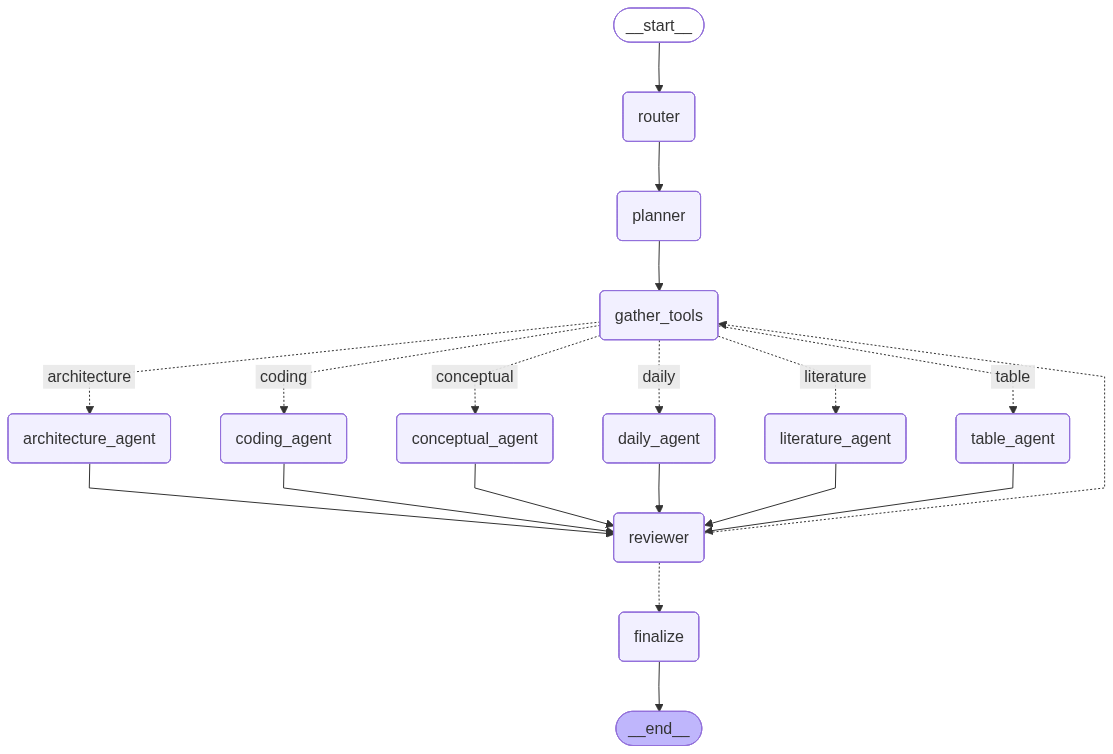

In [66]:
# Граф 
app = build_graph_with_retry_loop()
show_graph(app)

In [67]:
# Запросы
def run_experiments():
    queries = [
        # Концептуальный вопрос
        "Объясни разницу между object tracking и object detection задачами компьютерного зрения.",
        # Архитектура
        "Как спроектировать трекер для Multi-Object tracking, используя основные методы Computer Vision, какая будет архитектура трекера?",
        # Программирование
        "Напиши код трекера используя Observation center подход.",
        # Повседневная задача
        "Как добраться до Зимнего дворца от Мариинского театра?",
        # Создание таблицы
        "Создай таблицу технологий компьютерного зрения."
        # Обзор литературы
        "Расскажи о книге 'Игра в бисер', проведи её анализ, темы, которые автор поднимает в истории."
    ]

    app = build_graph_with_retry_loop()  
    results = []
    
    def llm_factory(temp: float):
        return get_llm(temperature=temp)
    
    for i, q in enumerate(queries, 1):
        out = run_system(q, thread_id=f"exp_{i}")
        comment_obj = make_experiment_comment(llm_factory, out)
        results.append({
            "query": q,
            "intent": out.get("intent"),
            "activated_nodes": out.get("activated_nodes", []),
            "handoff": out.get("handoff_log", []),
            "tools_used_count": len(out.get("tool_calls", [])),
            "memory_used": bool(out.get("memory_hits")),
            "memory_summary": out.get("memory_summary", ""),
            "answer_head": (out.get("final_answer", "") or "")[:400],
            "comment": comment_obj.model_dump(),
        })

    return results


In [68]:
out = run_system("Напиши код трекера объектов для решения задач компьютерного зрения.", thread_id="u1")
print(out["final_answer"])
print("intent:", out["intent"])
print("nodes:", out["activated_nodes"])
print("handoff:", out["handoff_log"])
print("tools_used:", len(out["tool_calls"]))
print("memory:", out["memory_summary"])
exp = run_experiments()
print(json.dumps(exp, ensure_ascii=False, indent=2))


===---NODE: router---===
handoff: ['[handoff] router -> coding | Запрос требует реализации кода трекера объектов, что относится к категории coding. История взаимодействий содержит примеры исправления кода, но текущий запрос напрямую направлен на написание кода для задачи компьютерного зрения.']
tool_calls + 0
partial: 
final_answer: 

===---NODE: planner---===
handoff: ['[handoff] router -> coding | Запрос требует реализации кода трекера объектов, что относится к категории coding. История взаимодействий содержит примеры исправления кода, но текущий запрос напрямую направлен на написание кода для задачи компьютерного зрения.']
tool_calls + 0
partial: 
final_answer: 

===---NODE: gather_tools---===
handoff: ['[handoff] router -> coding | Запрос требует реализации кода трекера объектов, что относится к категории coding. История взаимодействий содержит примеры исправления кода, но текущий запрос напрямую направлен на написание кода для задачи компьютерного зрения.']
tool_calls + 2
partial